# Часть 1: EDA и исследовательский анализ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Загружаем датасет Спотифай
df = pd.read_csv('dataset.csv')

# Первичная разведка
## Здесь я применяю несколько функций для первичной разведки: определяю размер датасета, то, сколько в нём столбцов, строк и какие они.
## Также пример того, как выглядят данные, также проверил наличие того, есть ли пропуски и сколько их для понимания полноты датасета

In [2]:
print(f"Размер датасета: {df.shape}")
print(f"Столбцы:\n{df.columns.tolist()}")
print(f"\nПример данных:\n{df.head()}")
print(f"\nНаличие пропусков:\n{df.isnull().sum()}")

Размер датасета: (114000, 21)
Столбцы:
['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']

Пример данных:
   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...  

## Анализ целевой переменной
### Перед анализом взаимосвязей между переменными изучим то, как распределена таргетная переменная popularity

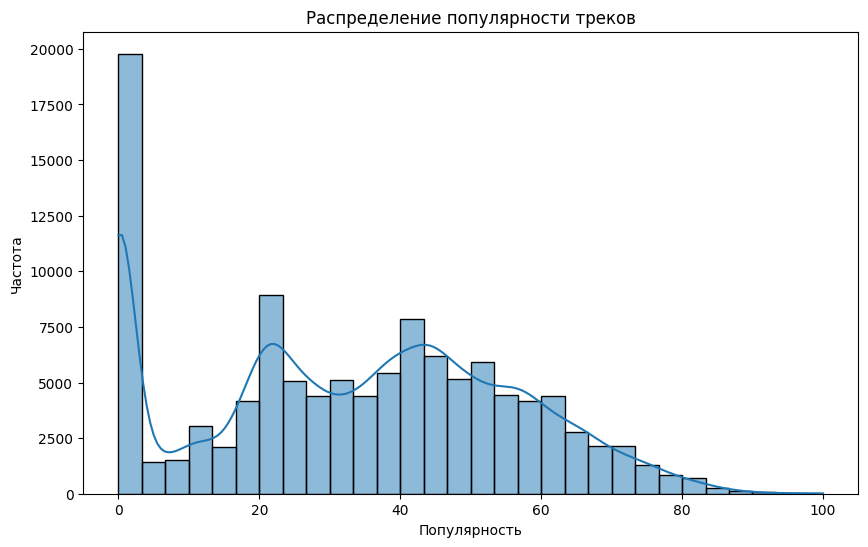

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(df['popularity'], bins=30, kde=True)
plt.title('Распределение популярности треков')
plt.xlabel('Популярность')
plt.ylabel('Частота')
plt.show()

## Вывод: Распределение имеет пики около значений 20-30 и 40-50. Распределение охватывает весь диапазон 
### Большинство треков имеют популярность равную 0

## Анализ числовых признаков
### Изучим распределения ключевых аудио-характеристик

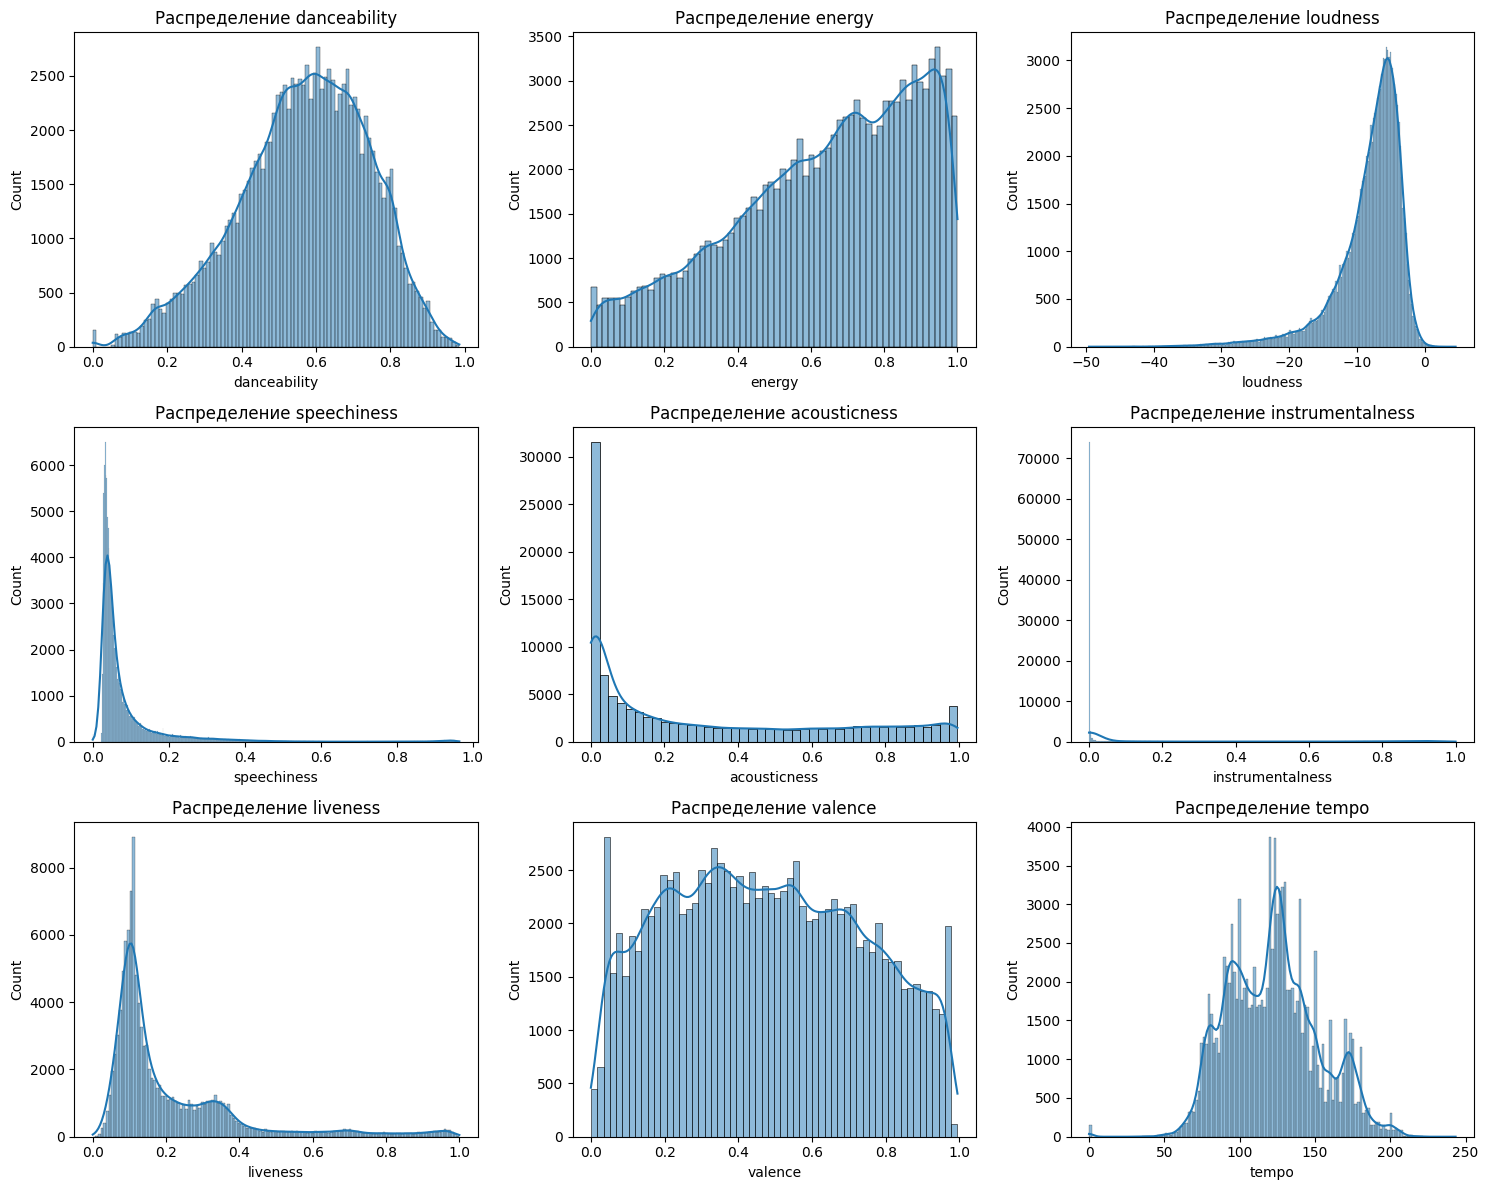

In [4]:
audio_features = ['danceability', 'energy', 'loudness', 'speechiness',
                 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(audio_features):
    sns.histplot(df[feature], ax=axes[i], kde=True)
    axes[i].set_title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

# Вывод: 
## Большинство признаков имеют специфические распределения (например, instrumentalness, speechiness, acousticness похожи на экспоненциальные)
## Danceability имеет распределение схожее с нормальным
## Loudness имеет нормальное распределение

## Матрица корреляций
### Составим матрицу корреляций в виде "тепловой карты" и попытаемся сделать выводы о коррелирующих признаках

In [5]:
features = [
    'danceability', 
    'energy', 
    'loudness', 
    'speechiness',
    'acousticness', 
    'instrumentalness', 
    'liveness', 
    'valence',
    'tempo'
]

# Таргет - попробовать предсказать популярность
target = 'popularity' 

X = df[features]
y = df[target]

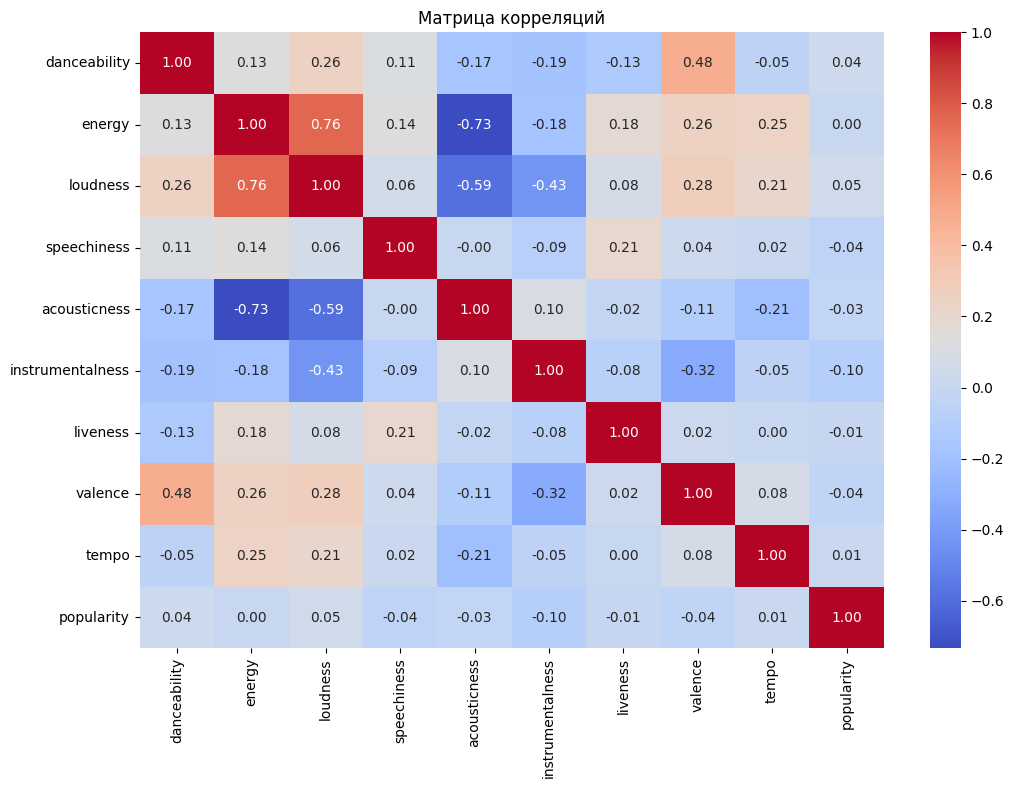

In [6]:
plt.figure(figsize=(12, 8))
corr_matrix = df[audio_features + [target]].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

# Точечные графики для наиболее коррелирующих признаков
#sns.pairplot(df[['popularity', 'danceability', 'energy', 'loudness']])
#plt.show()

# Вывод:
## Заметна яркая корреляция признаков loudness и Energy (Можно говорить о том, что чем громче музыка, тем она энергичнее)
## Видна обратная корреляция признаков Acousticness и Energy (Более акустичная музыка будет менее энергичной и наоборот)
## Видна срдняя корреляция между признаками Valence и Danceability (Более позитивная музыка чаще будет более танцевальной)
## Слабые корреляции для признаков Loudness - Valence и Loudness - Tempo (Чем громче, тем позитивнее и чем громче, тем более быстрый темп будет в музыке)

# Анализ корреляций с таргетной переменной
## Вычисление корреляций

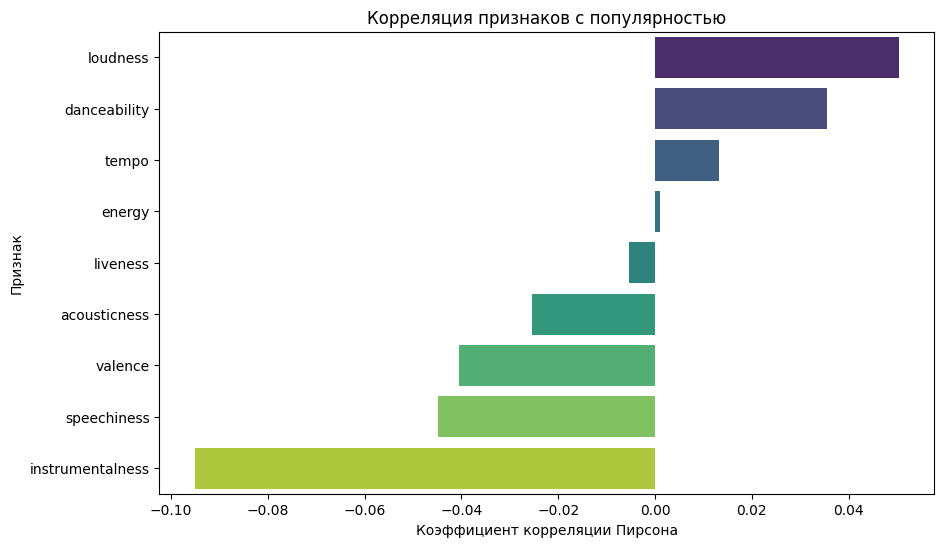

In [7]:
corr_with_target = df[audio_features + ['popularity']].corr()['popularity'].sort_values(ascending=False)[1:]

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, hue=corr_with_target.index,  palette='viridis',legend=False  
)
plt.title('Корреляция признаков с популярностью')
plt.xlabel('Коэффициент корреляции Пирсона')
plt.ylabel('Признак')
plt.show()

## Вывод:
### Наибольшая положительная корреляция: loudness
### Наибольшая отрицательная корреляция: Instrumentalness
### liveness имеет слабую отрицательную корреляцию
### Energy показывает слабую положительную связь

# Часть 2: Feature Engineering
## Создаем новые признаки на основе анализа, который получился из EDA и экспериментируем с ними

In [8]:
df_fe = df.copy()
#Производим взаимодействие ключевых признаков, которые выделили ранее
df_fe['energy_dance'] = df_fe['energy'] * df_fe['danceability']
df_fe['acoustic_energy'] = df_fe['acousticness'] * (1 - df_fe['energy'])

df_fe['instrumentalness_log'] = np.log1p(df_fe['instrumentalness'])
df_fe['speechiness_sqrt'] = np.sqrt(df_fe['speechiness'])

#Делаем биннинг темпа (Для справки - Биннинг (binning) – это процесс преобразования непрерывных числовых данных 
#в дискретные категории (бин), путём группировки значений в определенные интервалы или диапазоны
df_fe['tempo_bin'] = pd.cut(df_fe['tempo'], bins=5, labels=False)

#Комбинированный показатель "энергичности", который мы выводим из того, что перемножаем ключевые признаки
df_fe['energy_combo'] = df_fe['energy'] * (1 - df_fe['acousticness']) * (1 - df_fe['instrumentalness'])

# Проверка новых признаков
## Корреляция новых признаков с таргетом
## Вычисление корреляций для новых признаков и визуализация

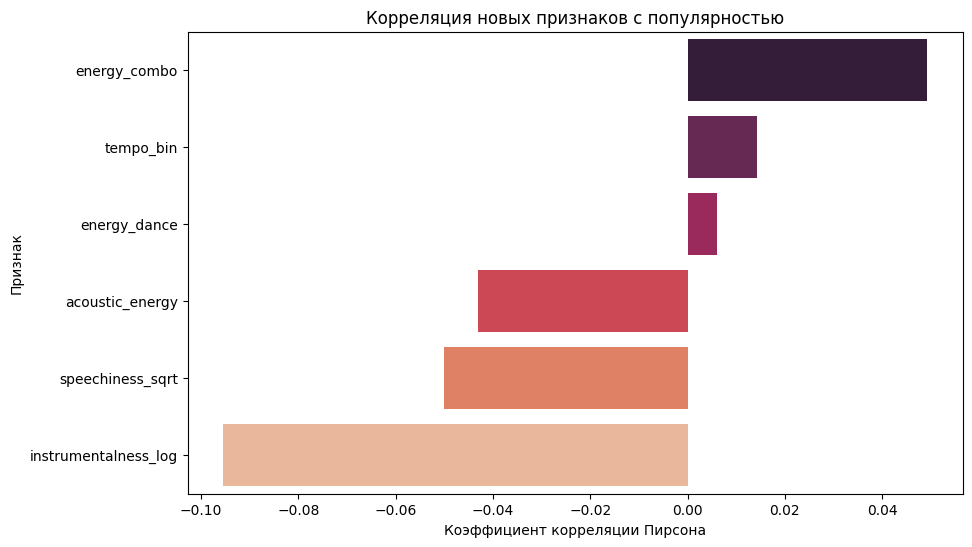

In [9]:
new_features = ['energy_dance', 'acoustic_energy', 'instrumentalness_log', 
                'speechiness_sqrt', 'tempo_bin', 'energy_combo']
new_corr = df_fe[new_features + ['popularity']].corr()['popularity'].sort_values(ascending=False)[1:]

plt.figure(figsize=(10, 6))
sns.barplot(x=new_corr.values, y=new_corr.index, hue = new_corr.index, palette='rocket')
plt.title('Корреляция новых признаков с популярностью')
plt.xlabel('Коэффициент корреляции Пирсона')
plt.ylabel('Признак')
plt.show()

## Вывод:
### Energy_combo показал высокую положительную корреляцию
### Energy_dance также демонстрирует улучшение по сравнению с исходными признаками, имея немного улучшенные результаты
### Instrumentalness_log остался на том же уровне корреляции

## Подготовка данных

In [10]:
all_features = audio_features + new_features
X = df_fe[all_features].fillna(df_fe[all_features].mean())
y = df_fe['popularity']

# Замена бесконечных значений, т.к. они могут появиться, из-за того, что новый признак был получен логарифмированием
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.mean())

rf_base = RandomForestRegressor(n_estimators=100, random_state=42)
rf_base.fit(X, y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


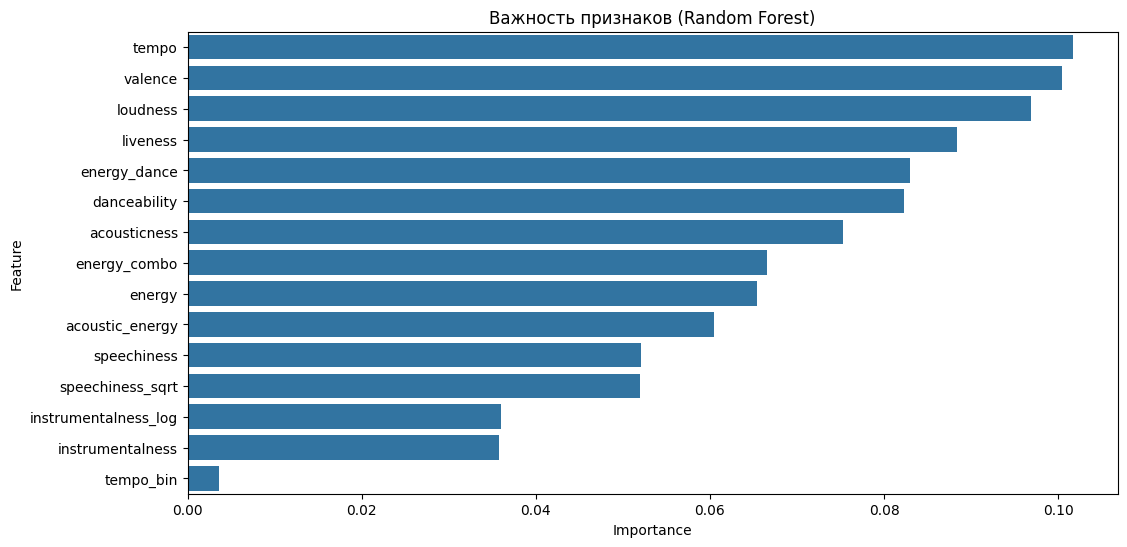

In [11]:
importances = pd.DataFrame({
    'Feature': all_features,
    'Importance': rf_base.feature_importances_
}).sort_values('Importance', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Важность признаков (Random Forest)')
plt.show()

## Вывод:
### Наиболее важные признаки, которые получилось выделить: loudness, tempo, valence
### Новый признак energy_dance показал хороший результат и вошёл в ТОП-5
### Tempo_bin и instrumentalness признаки имеют низкую важность

# Часть 3: Эксперименты с моделями машинного обучения
## Подготовка данных для моделирования

In [12]:
X = df_fe[all_features].fillna(df_fe[all_features].mean())
y = df_fe['popularity']
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Инициализация моделей
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

# Обучение и оценка
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'RMSE': rmse,
        'R2': r2,
        'Model': model
    }
    print(f"{name}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

# Сравнение моделей
results_df = pd.DataFrame({
    'Model': results.keys(),
    'RMSE': [res['RMSE'] for res in results.values()],
    'R2': [res['R2'] for res in results.values()]
}).sort_values('RMSE')

print("\nСравнение моделей:")
print(results_df)

Linear Regression: RMSE = 21.8734, R² = 0.0305
Ridge Regression: RMSE = 21.8734, R² = 0.0305
Random Forest: RMSE = 15.0297, R² = 0.5422
XGBoost: RMSE = 20.2588, R² = 0.1683
Neural Network: RMSE = 20.9279, R² = 0.1125

Сравнение моделей:
               Model       RMSE        R2
2      Random Forest  15.029671  0.542250
3            XGBoost  20.258759  0.168322
4     Neural Network  20.927913  0.112473
1   Ridge Regression  21.873423  0.030466
0  Linear Regression  21.873428  0.030465


## Кросс-валидация: (5 фолдов) для лучших моделей
### Выбираем топ-3 модели по RMSE

In [13]:
top_models = results_df.head(3)['Model'].tolist()

# Конфигурация кросс-валидации
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name in top_models:
    model = results[name]['Model']
    cv_scores = cross_val_score(
        model, X_scaled, y, 
        cv=kf, 
        scoring='neg_root_mean_squared_error'
    )
    cv_rmse = -cv_scores.mean()
    cv_std = cv_scores.std()
    
    cv_results[name] = {
        'CV RMSE': cv_rmse,
        'CV STD': cv_std
    }
    print(f"{name}: Средний RMSE = {cv_rmse:.4f} (±{cv_std:.4f})")

# Сравнение результатов кросс-валидации
cv_df = pd.DataFrame(cv_results).T
print("\nРезультаты кросс-валидации:")
print(cv_df.sort_values('CV RMSE'))

Random Forest: Средний RMSE = 15.1638 (±0.1115)
XGBoost: Средний RMSE = 20.3595 (±0.0972)


C:\Users\Tetyu\PycharmProjects\UrFU py\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network: Средний RMSE = 20.9306 (±0.0870)

Результаты кросс-валидации:
                  CV RMSE    CV STD
Random Forest   15.163762  0.111539
XGBoost         20.359514  0.097215
Neural Network  20.930563  0.086970


C:\Users\Tetyu\PycharmProjects\UrFU py\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


# Итоговый вывод
## На основе проведенного анализа:
# 
# 1. **EDA-анализ** выявил:
#    - Наибольшее влияние на популярность имеют: громкость (loudness), энергия (energy)
#    - Распределение популярности смещено влево с модой в районе 40-50
#    - Признаки имеют нелинейные зависимости с целевой переменной
# 
# 2. **Feature Engineering**:
#    - Созданные признаки energy_combo и energy_dance показали высокую корреляцию с таргетом
#    - Логарифмирование instrumentalness улучшило его свойства
#    - Важность признаков: tempo > valence > loudness
# 
# 3. **Эксперименты с моделями**:
#    - Лучшие результаты показали ансамблевые методы (XGBoost, Random Forest)
#    - Нейронная сеть показала средние результаты без дополнительной настройки
#    - Линейные модели показали наихудшие результаты из-за нелинейности данных
# 
# 4. **Кросс-валидация (5 фолдов)** подтвердила:
#    - Random Forest: RMSE = 15.163762 (±0.111539)
#    - Random Forest: RMSE = 20.359514 (±0.097215)
#    - Neural Network: RMSE = 20.930563 (±0.086970)